In [18]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
import re

import numpy as np
import matplotlib.pyplot as plt

In [19]:
regex_params = r'Candidate\(args=\((\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+), (\d+(\.\d*)?|\.\d+)'
regex_fitness = r'Updating fitness with value (\d+(\.\d*)?|\.\d+)'
regex_mean = r'mean: (\d+(\.\d*)?|\.\d+)'
regex_gamma = r'Gamma factor: (\d+(\.\d*)?|\.\d+)'

In [47]:
def parse_file(path, regex_params, regex_fitness, regex_mean, regex_gamma):
    params = []
    fitness = []
    mean = []
    gamma = []
    
    f = os.path.join(os.environ.get('MSC_PROJECT'), path)
    with open(f, 'r') as fh:
        lines = fh.readlines() 

    for line in lines:
        matches_params = re.search(regex_params, line)
        matches_fitness = re.search(regex_fitness, line)
        matches_mean = re.search(regex_mean, line)
        matches_gamma = re.search(regex_gamma, line)
        
        if matches_params:
            x = [float(i) for i in matches_params.group(1,3,5,7)]
            params.append(x)
        if matches_fitness:
            fitness.append(float(matches_fitness.group(1)))
        if matches_mean:
            mean.append(float(matches_mean.group(1)))
        if matches_gamma:
            gamma.append(float(matches_gamma.group(1)))
            
    params = np.array(params)
    fitness = np.array(fitness)
    mean = np.array(mean)
    gamma = np.array(gamma)
    
    return params, fitness, mean, gamma

def plot_mean(means, names, ylim=[1,2], savefig_=None):
    for mean, name in zip(means, names):
        plt.plot(mean, label=name)
    plt.title('mean')
    plt.ylim(ylim)
    plt.ylabel('mean')
    plt.xlabel('#iter')
    plt.legend()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()


def plot_gamma(gammas, names, ylim=[1,5], alpha=0.9, figsize=(13,5), savefig_=None):
    plt.figure(figsize=figsize)

    for gamma, name in zip(gammas, names):
        plt.plot(gamma, label=name, alpha=alpha)

    plt.ylim(ylim)
    plt.title('gamma factor')
    plt.ylabel('gamma factor')
    plt.xlabel('#iter')
    plt.legend()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()
    
def plot_tauE(params, names, params_idx=0, ylim=[0.1,5], alpha=0.9, figsize=(13,5), savefig_=None):
    plt.figure(figsize=figsize)

    for param, name in zip(params, names):
        plt.plot(param[:,params_idx], label=name, alpha=alpha)
    plt.ylim(ylim)
    plt.ylabel('tauE')
    plt.xlabel('#iter')
    plt.title('tauE')
    plt.legend()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()
    
def plot_wE(params, names, params_idx=1, ylim=[200,1000], alpha=0.9, figsize=(13,5), savefig_=None):
    plt.figure(figsize=figsize)

    for param, name in zip(params, names):
        plt.plot(param[:,params_idx], label=name, alpha=alpha)
    plt.ylim(ylim)
    plt.ylabel('wE')
    plt.xlabel('#iter')
    plt.title('wE')
    plt.legend()
    if savefig_:
        plt.savefig(savefig_)
    plt.show()
    
def print_mean_std(params, names):
    for param, name in zip(params, names):
        print(name)
        print(f'tauE mean {param[:,0].mean():.4f} - std {param[:,0].std():.4f}')
        print(f'wE mean {param[:,1].mean():.4f} - std {param[:,1].std():.4f}')
        print()

# TL2

In [53]:
DE_p, DE_f, DE_m, DE_g = parse_file('optimisation_scripts/TL2/outputs/TL2_DE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
PSO_p, PSO_f, PSO_m, PSO_g = parse_file('optimisation_scripts/TL2/outputs/TL2_PSO_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
SQP_p, SQP_f, SQP_m, SQP_g = parse_file('optimisation_scripts/TL2/outputs/TL2_SQP_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_p, TPDE_f, TPDE_m, TPDE_g = parse_file('optimisation_scripts/TL2/outputs/TL2_TPDE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_1000_p, TPDE_1000_f, TPDE_1000_m, TPDE_1000_g = parse_file('optimisation_scripts/TL2/outputs/TL2_TPDE_1000.out', regex_params, regex_fitness, regex_mean, regex_gamma)


names = ['DE', 'PSO', 'SQP', 'TPDE', 'TPDE_1000']
TL2_means = [DE_m, PSO_m, SQP_m, TPDE_m, TPDE_1000_m]
TL2_gammas = [DE_g, PSO_g, SQP_g, TPDE_g, TPDE_1000_g]
TL2_fitness = [DE_f, PSO_f, SQP_f, TPDE_f, TPDE_1000_f]
TL2_params = [DE_p, PSO_p, SQP_p, TPDE_p, TPDE_1000_p]

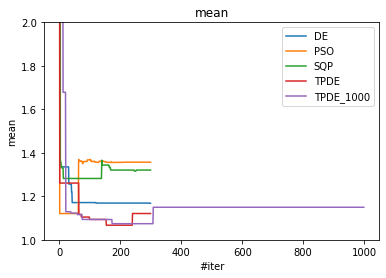

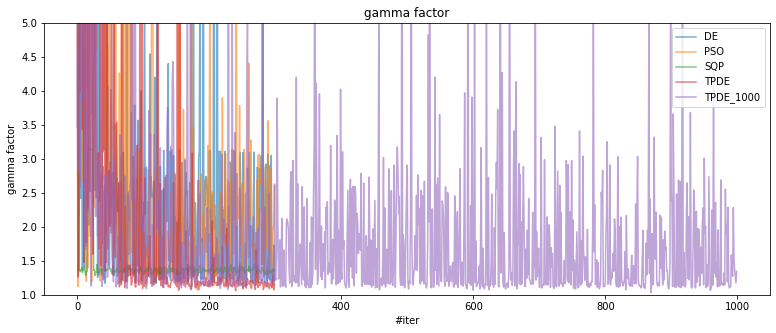

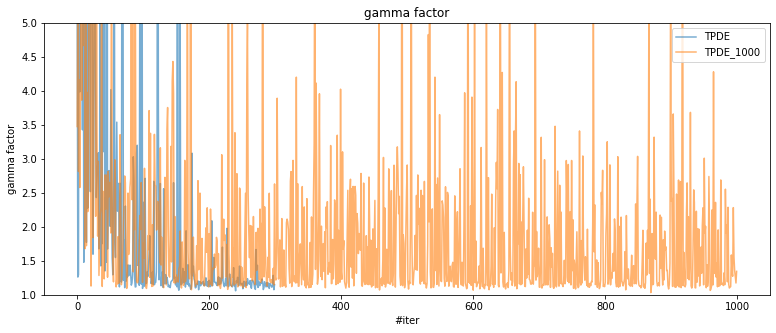

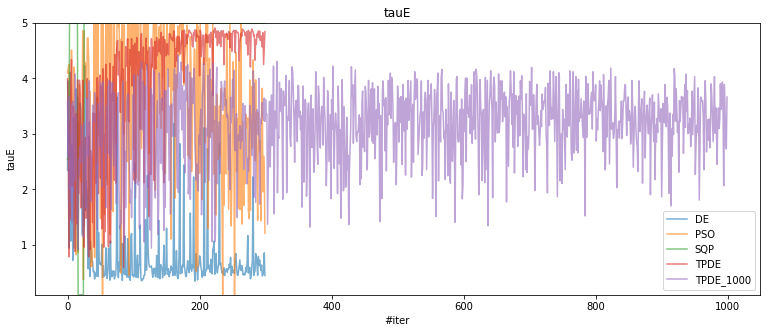

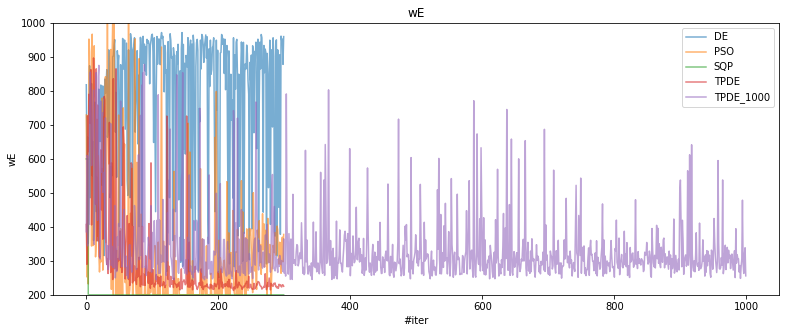

DE
tauE mean 0.8879 - std 0.7935
wE mean 769.2316 - std 213.4216

PSO
tauE mean 3.4942 - std 1.2845
wE mean 341.3392 - std 202.6417

SQP
tauE mean 4.8273 - std 0.8663
wE mean 204.0369 - std 39.7958

TPDE
tauE mean 4.0311 - std 1.1112
wE mean 300.0034 - std 151.7583

TPDE_1000
tauE mean 3.1491 - std 0.6884
wE mean 337.0455 - std 108.9767



In [56]:
plot_mean(TL2_means, names)
plot_gamma(TL2_gammas, names,  alpha=0.6)
plot_gamma([TPDE_g, TPDE_1000_g], ['TPDE', 'TPDE_1000'], alpha=0.6)
plot_tauE(TL2_params, names, alpha=0.6)
plot_wE(TL2_params, names, alpha=0.6)
print_mean_std(TL2_params, names)

# CL1

In [66]:
DE_p, DE_f, DE_m, DE_g = parse_file('optimisation_scripts/CL1/outputs/CL1_DE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
PSO_p, PSO_f, PSO_m, PSO_g = parse_file('optimisation_scripts/CL1/outputs/CL1_PSO_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
SQP_p, SQP_f, SQP_m, SQP_g = parse_file('optimisation_scripts/CL1/outputs/CL1_SQP_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_p, TPDE_f, TPDE_m, TPDE_g = parse_file('optimisation_scripts/CL1/outputs/CL1_TPDE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_1000_p, TPDE_1000_f, TPDE_1000_m, TPDE_1000_g = parse_file('optimisation_scripts/CL1/outputs/CL1_TPDE_1000.out', regex_params, regex_fitness, regex_mean, regex_gamma)


names = ['DE', 'PSO', 'SQP', 'TPDE', 'TPDE_1000']
CL1_means = [DE_m, PSO_m, SQP_m, TPDE_m, TPDE_1000_m]
CL1_gammas = [DE_g, PSO_g, SQP_g, TPDE_g, TPDE_1000_g]
CL1_fitness = [DE_f, PSO_f, SQP_f, TPDE_f, TPDE_1000_f]
CL1_params = [DE_p, PSO_p, SQP_p, TPDE_p, TPDE_1000_p]

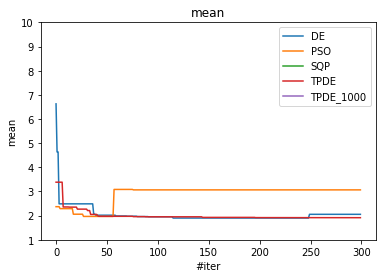

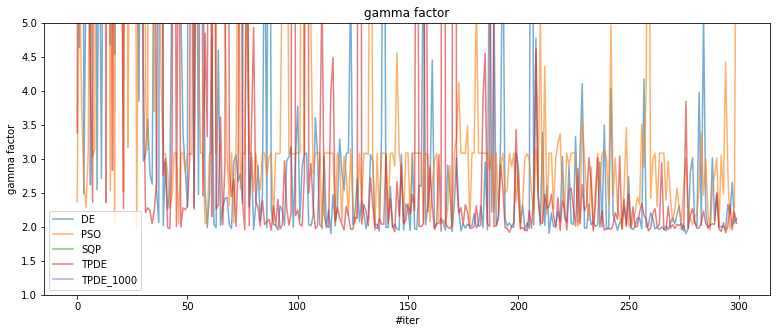

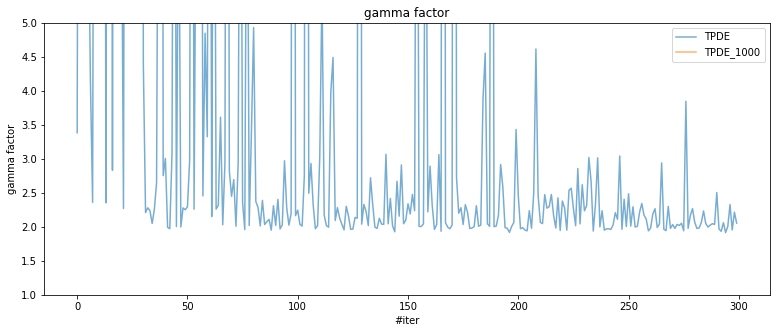

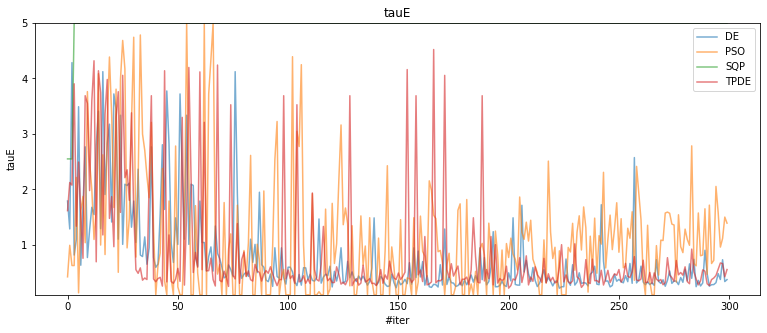

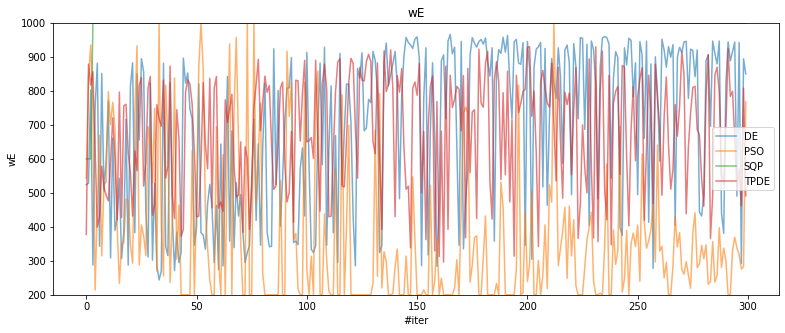

DE
tauE mean 0.7816 - std 0.8062
wE mean 692.3199 - std 238.9155

PSO
tauE mean 1.1435 - std 1.0914
wE mean 373.7743 - std 212.5776

SQP
tauE mean 4.9755 - std 0.2438
wE mean 995.9896 - std 39.7984

TPDE
tauE mean 0.8733 - std 1.0407
wE mean 676.5652 - std 169.4562



In [71]:
plot_mean(CL1_means, names, ylim=[1,10])
plot_gamma(CL1_gammas, names, ylim=[1,5], alpha=0.6)
plot_gamma([TPDE_g, TPDE_1000_g], ['TPDE', 'TPDE_1000'], alpha=0.6)
plot_tauE([DE_p, PSO_p, SQP_p, TPDE_p], ['DE', 'PSO', 'SQP', 'TPDE'], alpha=0.6)
plot_wE([DE_p, PSO_p, SQP_p, TPDE_p], ['DE', 'PSO', 'SQP', 'TPDE'], alpha=0.6)
print_mean_std([DE_p, PSO_p, SQP_p, TPDE_p], ['DE', 'PSO', 'SQP', 'TPDE'])

# TN2

In [72]:
DE_p, DE_f, DE_m, DE_g = parse_file('optimisation_scripts/TN2/outputs/TN2_DE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
PSO_p, PSO_f, PSO_m, PSO_g = parse_file('optimisation_scripts/TN2/outputs/TN2_PSO_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
SQP_p, SQP_f, SQP_m, SQP_g = parse_file('optimisation_scripts/TN2/outputs/TN2_SQP_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
TPDE_p, TPDE_f, TPDE_m, TPDE_g = parse_file('optimisation_scripts/TN2/outputs/TN2_TPDE_300.out', regex_params, regex_fitness, regex_mean, regex_gamma)
#TPDE_1000_p, TPDE_1000_f, TPDE_1000_m, TPDE_1000_g = parse_file('optimisation_scripts/TN2/outputs/TN2_TPDE_1000.out', regex_params, regex_fitness, regex_mean, regex_gamma)


names = ['DE', 'PSO', 'SQP', 'TPDE']#, 'TPDE_1000']
TN2_means = [DE_m, PSO_m, SQP_m, TPDE_m]#, TPDE_1000_m]
TN2_gammas = [DE_g, PSO_g, SQP_g, TPDE_g]#, TPDE_1000_g]
TN2_fitness = [DE_f, PSO_f, SQP_f, TPDE_f]#, TPDE_1000_f]
TN2_params = [DE_p, PSO_p, SQP_p, TPDE_p]#, TPDE_1000_p]

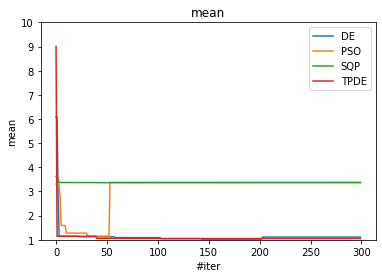

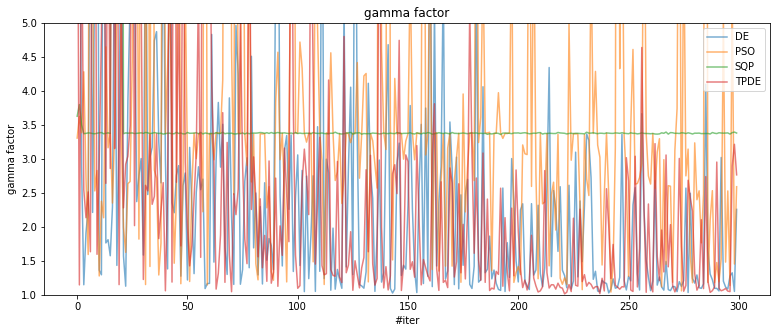

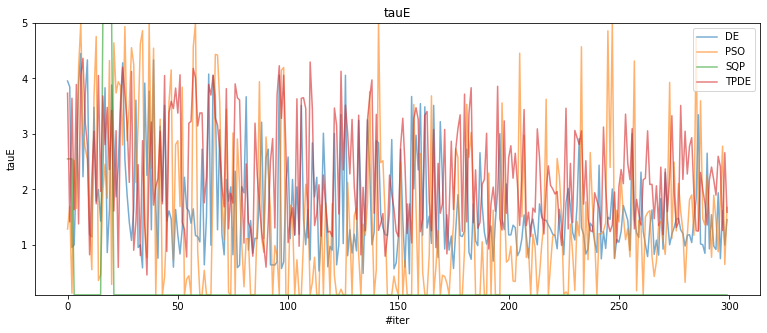

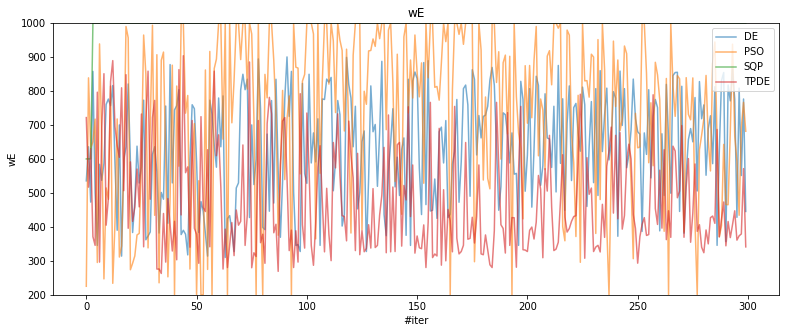

DE
tauE mean 1.6806 - std 0.9311
wE mean 632.4061 - std 161.2970

PSO
tauE mean 1.5404 - std 1.3882
wE mean 733.3343 - std 244.2385

SQP
tauE mean 0.2063 - std 0.6699
wE mean 995.9706 - std 39.7965

TPDE
tauE mean 2.2851 - std 0.9586
wE mean 476.4508 - std 156.2779



In [74]:
plot_mean(TN2_means, names, ylim=[1,10])
plot_gamma(TN2_gammas, names, ylim=[1,5], alpha=0.6)
#plot_gamma([TPDE_g, TPDE_1000_g], ['TPDE', 'TPDE_1000'], alpha=0.6)
plot_tauE(TN2_params, names, alpha=0.6)
plot_wE(TN2_params, names, alpha=0.6)
print_mean_std(TN2_params, names)